In [1]:
using MPSTime
using Random
using Plots
using PrettyTables
using DSP
using Statistics
using Serialization

In [2]:
macro noprint(expr)
    quote
        let so = stdout
            redirect_stdout(devnull)
            res = $(esc(expr))
            redirect_stdout(so)
            res
        end
    end
end;

In [3]:
function params(d::Union{Int, Vector},
    chi_max::Union{Int, Vector},
    ntimepoints::Union{Int, Vector},
    ntrain_instances::Union{Int, Vector},
    ntest_instances::Union{Int, Vector},
    sigma::Union{Number, Vector};
    period::Union{Number, Vector}=nothing,
    sweeps::Union{Int, Vector}=20,
    )

    rng = Xoshiro(1)

    params = Dict(
    :d => d,
    :chi_max => chi_max,
    :ntimepoints => ntimepoints,
    :ntrain_instances => ntrain_instances,
    :ntest_instances => ntest_instances,
    :sigma => sigma,
    :period => period,
    :final_multiplier => final_multiplier,
    :rng => rng,
    :sweeps => sweeps
    )

    return params
end;

In [4]:
function create_overlapping_windows(time_series::Array{Number, 2}, ntimepoints::Int64)
    nsamples = length(time_series) - ntimepoints + 1
    time_series_windows = Array{Number, 2}(undef, ntimepoints, nsamples)
    for i in 1:nsamples
        time_series_windows[:,i] = time_series[i:i+ntimepoints-1]
    end
    return time_series_windows
end;

In [5]:
function train_test_split(time_series::Array{Number, 2}; split_ratio::Float64 = 0.8)
    nsamples = size(time_series, 2)
    split_idx = Int(floor(nsamples * split_ratio))
    
    train_data = time_series[:, 1:split_idx]
    test_data = time_series[:, split_idx+1:end]
    
    return (train_data, test_data)
end;

In [6]:
function generate_ar_data(ts_length::Int; phi::Union{Number,Vector{Float64}} = 0.5, sigma::Number = 0.0)
    if typeof(phi) == Number
        phi = [phi]
    end

    p = length(phi)
    time_series = Array{Number, 2}(undef, 1, ts_length)
    time_series[1, 1:p] = randn(p)
    
    for t in (p+1):ts_length
        time_series[1, t] = sum(phi .* time_series[t-p:t-1]) + sigma * randn()
    end
    
    return time_series;
end;

In [7]:
function generate_logistic_map(ts_length::Int; r::Number = 2.5, x0::Number = 0.5)
    time_series = Array{Number, 2}(undef, 1, ts_length)
    time_series[1, 1] = x0
    
    for t in 2:ts_length
        time_series[1, t] = r * time_series[t-1] * (1 - time_series[t-1])
    end
    
    return time_series
end;

In [8]:
function generate_sinusoidal(ts_length::Int; freq::Number = 0.01, amp::Number = 1, phase::Number=0.0, sigma::Number=0.0)
    time_series = Array{Number, 2}(undef, 1, ts_length)
    
    for t in 1:ts_length
        time_series[1, t] = amp * sin(2 * π * freq * t + phase) + sigma * randn()
    end
    
    return time_series
end;

In [9]:
function generate_time_series(ts_params::Dict)

    ts_type = ts_params[:ts_type]
    ts_length = ts_params[:ts_length]

    time_series = Array{Number, 2}(undef, 1, ts_length)

    if ts_type == :sine
        time_series = generate_sinusoidal(ts_length; freq = ts_params[:s_freq],
                                        amp = ts_params[:s_amp],
                                        phase = ts_params[:s_phase],
                                        sigma = ts_params[:s_sigma])
        
    elseif ts_type == :ar
        time_series = generate_ar_data(ts_length; phi = ts_params[:ar_phi],
                                        sigma = ts_params[:ar_sigma])

    elseif ts_type == :lm
        time_series = generate_logistic_map(ts_length; r = ts_params[:lm_r],
                                        x0 = ts_params[:lm_x0])

    else
        error("Invalid method. Choose :sine (Sinusoidal), :l_m (Logistic Map), :ar (AR(n))")
    end

    ts_wndw = create_overlapping_windows(time_series, ts_params[:mps_N])

    ts_train_wndw, ts_test_wndw = train_test_split(ts_wndw; split_ratio = ts_params[:ts_split])

    return (ts_train_wndw, ts_test_wndw)
end;

In [136]:
function plot_windowed_data(windowed_data::Array{Number, 2})
    
    ntimepoints = size(windowed_data, 1)
    nsamples = size(windowed_data, 2)

    p = plot()
    
    for sample = 1:nsamples

        x_vals = sample:(sample + ntimepoints - 1)

        plot!(x_vals, windowed_data[:, sample], label="", lw=1)

    end
    display(p)
    
end;

In [161]:
function plot_x_t_vs_x_t1(windowed_data::Array{Number, 2})
    ntimepoints = size(windowed_data, 1)
    nsamples = size(windowed_data, 2)

    out = Array{Number, 2}(undef, 1, ntimepoints + nsamples - 1)
    out[1, 1:ntimepoints] = ts_train_wndw[:,1]
    
    for i in 2:nsamples
    
        out[1, ntimepoints + i - 1] = ts_train_wndw[end, i]
    
    end

    x_t = out[1:end-1]
    x_t1 = out[2:end]
        
    p = scatter(x_t, x_t1, label="", lw=1, color = "red", marker=:circle)
    
    display(p)
end;

In [181]:
function ts_diff(time_series::Array{Number, 2})

    ts_diff = Array{Number, 2}(undef, 1, length(time_series))

    ts_diff[1, 1] = time_series[1,1]
    ts_diff[1, 2:end] = time_series[2:end] .- time_series[1:end-1]
    return ts_diff
end;

In [ ]:
function ts_minmax(time_series::Array{Number, 2})
    ts_min, ts_max = minimum(time_series), maximum(time_series)

    ts_minmax = Array{Number, 2}(undef, 1, length(time_series))

    ts_minmax[1,:] = (time_series .- ts_min) ./ (ts_max - ts_min)

    return ts_minmax
end;

In [191]:
function ts_zscore(time_series::Array{Number, 2})
    ts_mean, ts_stderr = mean(time_series), std(time_series)

    print(ts_mean, " ", ts_stderr)

    ts_zscore = Array{Number, 2}(undef, 1, length(time_series))

    ts_zscore[1,:] = (time_series .- ts_mean) ./ (ts_stderr)

    return ts_zscore
end;

3.504495163657573e-17 0.7074605999633481

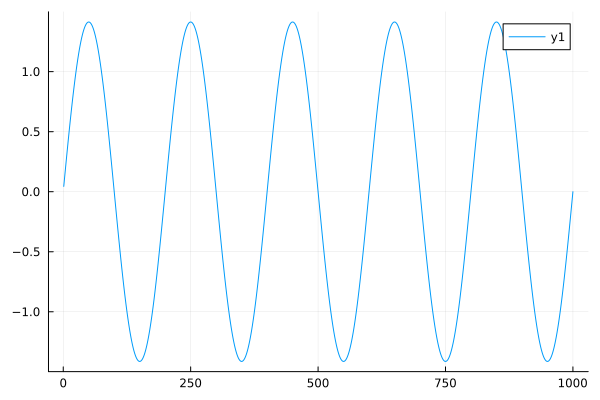

In [192]:
time_series = generate_sinusoidal(ts_params[:ts_length]; freq = ts_params[:s_freq],
                                        amp = ts_params[:s_amp],
                                        phase = ts_params[:s_phase],
                                        sigma = ts_params[:s_sigma])


plot(ts_zscore(time_series)[:])

In [ ]:
ts_params = Dict(
    :ts_type => :ar,
    :ts_length => 1000,
    :ts_split => 0.8,
    :ts_preprocess => :diff, :zscore, :minmax, 
    
    :mps_N => 10,

    # Sine Related Metrics
    :s_freq => 0.005,
    :s_amp => 1.0,
    :s_phase => 0.0,
    :s_sigma => 0.0,

    #AR(n) Related Metrics
    :ar_phi => 0.9,
    :ar_sigma => 0.1,

    #Logistic Map Related Metrics
    :lm_r => 4,
    :lm_x0 => 0.2

);

In [160]:
ts_train_wndw, ts_test_wndw = @noprint generate_time_series(ts_params);

In [141]:
print(size(ts_train_wndw) , " ", size(ts_test_wndw))

(10, 792) (10, 199)

In [142]:
# ploting = plot(legend=false, title="Both d=$d chi=$chi_max MSF", xlabel="'Time'", ylabel="Y-Value", lw=1)
# for (forecast_idx, (x_vals, current_vals)) in data_steps
#     x_vals_sliced = x_vals[1:end-1]
#     current_vals_sliced = current_vals[1:end-1]
    
#     plot!(x_vals_sliced[:], current_vals_sliced[:], lw=0.7, c=:black, alpha=0.6, xlims=(0, 100))
#     plot!(Final[1,:], c=:red)
# end
# display(ploting)

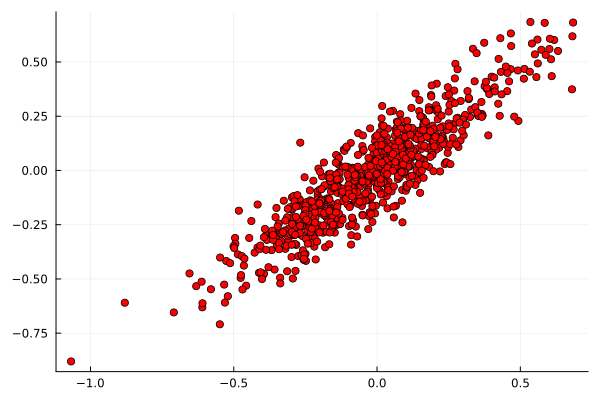

In [162]:
plot_x_t_vs_x_t1(ts_train_wndw)

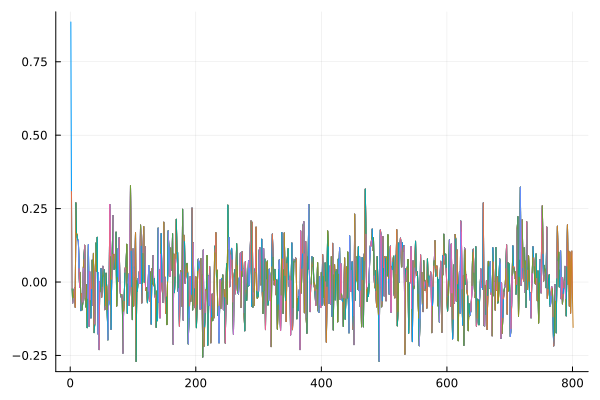

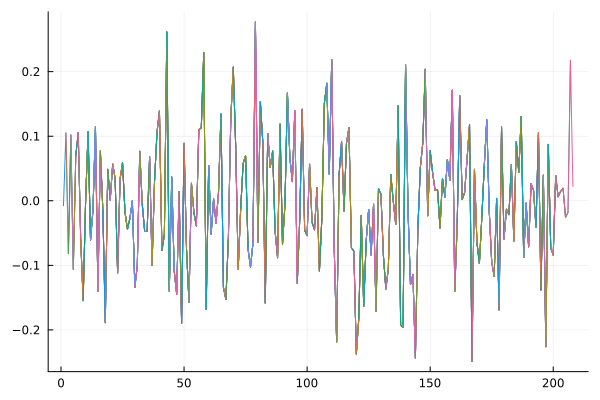

In [152]:
plot_windowed_data(ts_train_wndw)
plot_windowed_data(ts_test_wndw)